<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="6"> TAF MCE - 2021</span></p>
<p><font size="5">  UE C - Numerical Methods </font></p>
<p></p>
<p><font size="4">  Parallel computing in Julia </font></p>
</p></br>
<p><b><font size="4"> By Martina María BALBI ANTUNES and Kevin MICHALEWICZ </font></b></p>
</p>
</CENTER>

In [1]:
# using Pkg
# Pkg.add("Images")
# Pkg.add("MAT")

using MAT
using Plots
using Images
using Distributed
CPU_CORES = 4 # number of cores on the machine
addprocs(CPU_CORES - 1);
@everywhere using LinearAlgebra

using Distributed

pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

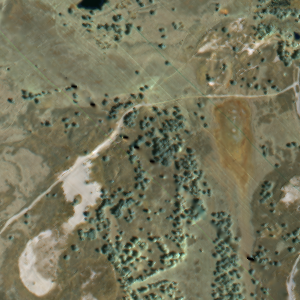

In [2]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

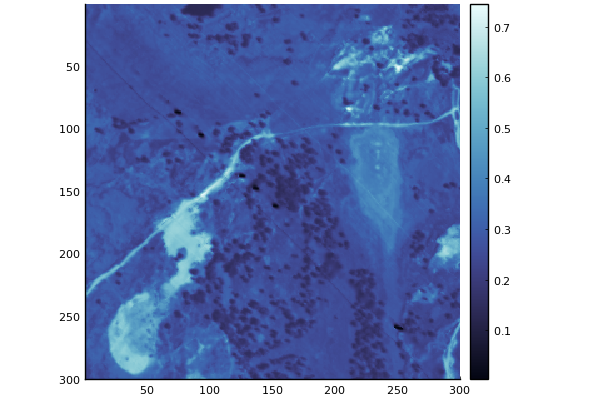

In [3]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

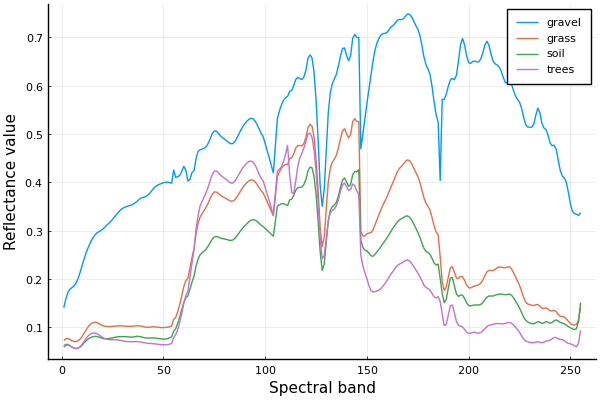

In [4]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [5]:
img_small = img[1:100,1:100,:]; # use a small crop of the image first
# img_small = copy(img);

# 1. Introduction

The idea is to implement a projected gradient descent algorithm coded by us in a standard serial way and then using parallelization. After that, we perform a similar analysis using Julia libraries. The implementations will be done pixelwise, having one eight of the image per time and by passing the whole image at once.

# 2. Serial computing

## 2.1 Projected gradient descent algorithm

In [6]:
size(img_small)

(100, 100, 255)

In [7]:
#X = reshape(img_small, size(img_small)[1]^2, 255)' # we work with images that are vectors
X = reshape(img, size(img)[1]^2, 255)'
size(X)

(255, 90000)

In the next cell an implementation of the Projected Gradient Descent algorithm can be found. The two constraints were taken into account at once.

In [8]:
using LinearAlgebra: norm

@everywhere function ProjectedGradientDescent(X,S,f,∇f,f_stepsize)
    
    """
    projected gradient descent
    IN:
    ---
    X: data matrix
    S: endmember matrix
    f, ∇f: function to be minimized and its gradient
    OUT:
    ----
    A: abundance matrix
    """
    
    # Initialization 
    N, p = size(X,2), size(S,2)
    A_init = max.(zeros(p,N),rand(p,N))
    A = A_init
    precision = 1.e-4
    δ = 1 # we compute the norm of the difference of A between iterations i and i+1
    opt_stepsize =  0.012 # 2/opnorm(S'*S)
    final_stepsize = f_stepsize
    max_iter = 5000
    nb_iter_pgrad = 0 # number of iterations
    
    # Loop
    while ((δ > precision) || (δ == 0.0)) & (nb_iter_pgrad < max_iter)
        
        nb_iter_pgrad += 1
        A_hat = max.(zeros(p,N), A - opt_stepsize * ∇f(A,X,S)) # gradient step and taking max w.r.t zero
        δ = norm(A - A_hat)
        A = A_hat
    end
    
    # Final iteration
    A = A./sum(A, dims=1)
    A = max.(zeros(p,N), A - final_stepsize * ∇f(A,X,S))
    A = A./sum(A, dims=1)
    
    return A
    
end

The next function, when called, plots the colormaps corresponding to the four materials of interest: gravel, grass, soil and trees.

In [9]:
function plotFourMaps(A)
    heatmaps = []
    labels = ["Gravel", "Grass", "Soil", "Trees"]
    for i in 1:size(S,2)
        push!(heatmaps, heatmap(reshape(A[i,:], Int(sqrt(N)), Int(sqrt(N))), yflip=true, aspect_ratio=1, c=:ice, title=labels[i]))
    end
    plot(heatmaps...,layout=size(S,2), size=(800,600))
end

plotFourMaps (generic function with 1 method)

In [10]:
# Some important variables that are useful to be extracted at this point
N = size(X,2)
S = sources
A = zeros(size(S,2), N)

# We define the function to minimize and its gradient
@everywhere f(A,X,S)= (1/2)*tr((X-S*A)'*(X-S*A))
@everywhere ∇f(A,X,S) = S'*(S*A - X)

The first implementation is **pixelwise**:

In [11]:
f_stepsize = 0.005 # the final stepsize

@time begin
    for j = 1:N
        A[:,j] = ProjectedGradientDescent(X[:,j],S,f,∇f,f_stepsize)
    end
end

350.380766 seconds (862.12 M allocations: 501.578 GiB, 19.83% gc time, 0.29% compilation time)


This is how one column of the abundance matrix looks like. As expected, the sum of its components gives 1 as the result.

In [12]:
A[:,1]

4-element Vector{Float64}:
 0.02479651426751793
 0.43306020117599675
 0.15187496921469057
 0.39026831534179485

If the $\mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T}$ constraint is satisfied, then the sum of every $\mathbf{A}$ element should be 9000.

In [13]:
sum(A)

90000.0

First, the image is thresholded in such way that pixels with intensities lower to $0.5$ go to zero. That *mask* is multiplied (elementwise) with the obtained abundance matrix $\mathbf{A}$.

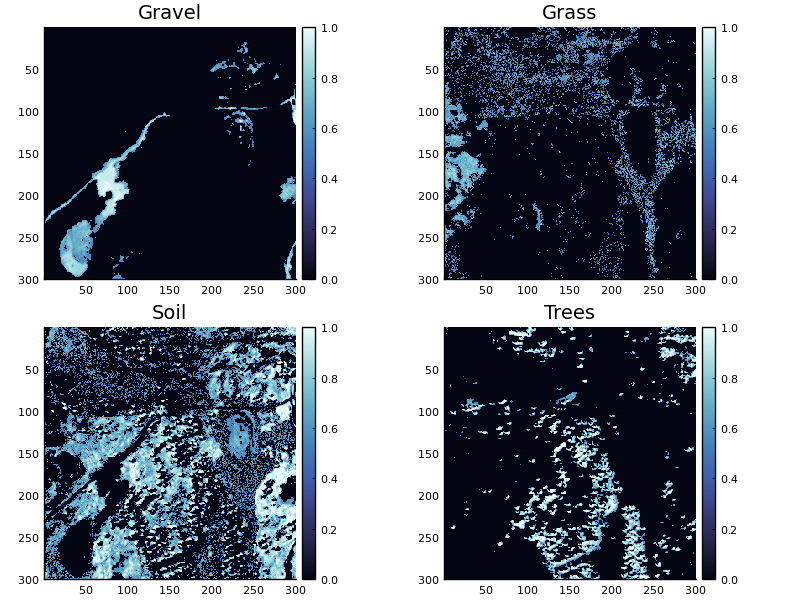

In [14]:
plotFourMaps(A.*(A.>0.5))

But, what would happen if **all the image** was processed **at once**?

In [15]:
# This option takes a lot of time

A = zeros(size(S,2), N)
f_stepsize = 0.0005

@time begin
    A = ProjectedGradientDescent(X,S,f,∇f,f_stepsize)
end

1137.462191 seconds (515.33 k allocations: 1.749 TiB, 8.58% gc time, 0.03% compilation time)


4×90000 Matrix{Float64}:
 0.00214198  0.00235588  0.00185788  …  0.042483  0.0668261  0.0577767
 0.575191    0.591632    0.619364       0.171696  0.0920858  0.0779501
 0.0011254   0.0462221   0.146402       0.785821  0.841088   0.864273
 0.421542    0.35979     0.232375       0.0       0.0        0.0

In [16]:
sum(A)

90000.0

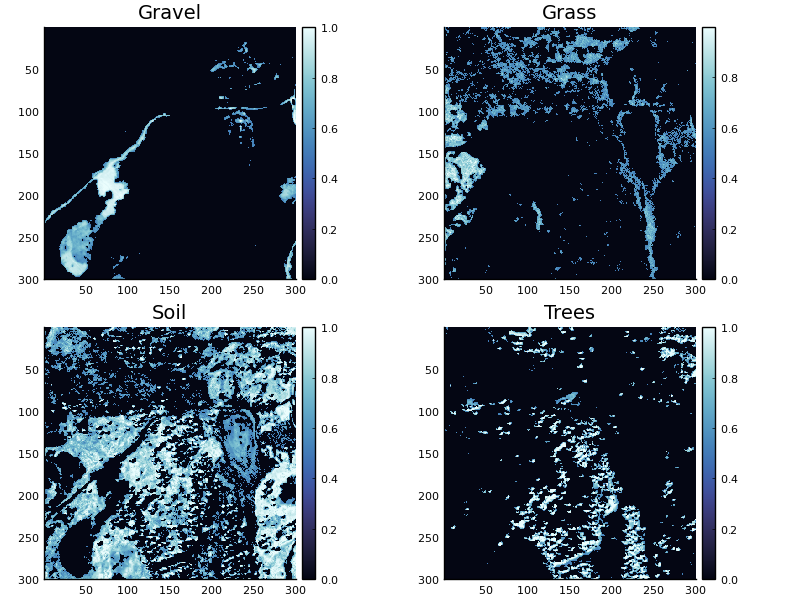

In [17]:
plotFourMaps(A.*(A.>0.5))

An intermediate case could also be tested: considering **one eight** of the image at a time.

In [18]:
A = zeros(size(S,2), N)
f_stepsize = 0.0005

@time begin
    for j = 1:N÷8:N
        A[:,j:j+N÷8-1] = ProjectedGradientDescent(X[:,j:j+N÷8-1],S,f,∇f,f_stepsize)
    end
end

475.664963 seconds (892.75 k allocations: 1.749 TiB, 3.73% gc time, 0.05% compilation time)


In [19]:
sum(A)

90000.0

In [20]:
A

4×90000 Matrix{Float64}:
 0.00222026  0.00247461  0.00210589  …  0.0425864  0.066399  0.057851
 0.554982    0.56067     0.555086       0.154482   0.0       0.0470091
 0.0230221   0.0814552   0.217548       0.802931   0.933601  0.89514
 0.419776    0.3554      0.22526        0.0        0.0       0.0

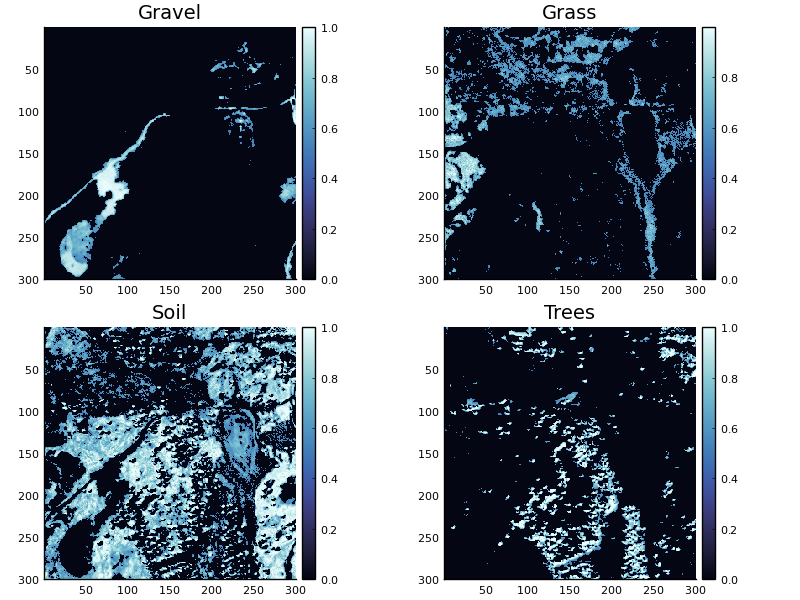

In [21]:
plotFourMaps(A.*(A.>0.5))

## 2.2 Julia libraries
In the following section we try to solve the problem by using the Julia's JuMP modeling language. Particularly, we will try out the performance using the ECOS and the Ipopt optimizers.

In [22]:
@everywhere using JuMP, ECOS, Ipopt

@everywhere function JuliaLibrariesJuMP(X,S,optimizer)
    """
    solution using Julia's JuMP modeling language
    IN:
    ---
    X: data matrix
    S: endmember matrix
    optimizer: optimizer to use (ECOS or Ipopt)
    OUT:
    ----
    A: abundance matrix
    """
    N, p = size(X,2), size(S,2)

    if optimizer == "ECOS"
        m = Model(with_optimizer(ECOS.Optimizer))
    elseif optimizer == "Ipopt"
        m = Model(with_optimizer(Ipopt.Optimizer))
    end
    
    @variable(m, A[1:p, 1:N])

    @constraint(m, A .>= 0)
    for i in 1:N
        @constraint(m, sum(A[:,i])==1)
    end
    
    @objective(m, Min, (1/2)*tr((X-S*A)'*(X-S*A)))
    
    set_silent(m)

    optimize!(m)

    return value.(A)

end

We will run the algorithm performing a pixelwise approach (others seem to take too much time).

Results with ECOS optimizer:

In [23]:
A = zeros(size(S,2), N)

@time begin
    for i = 1:N
        A[:,i] = JuliaLibrariesJuMP(X[:,i],S,"ECOS");
    end
end

181.778211 seconds (1.34 G allocations: 103.391 GiB, 5.16% gc time, 1.36% compilation time)


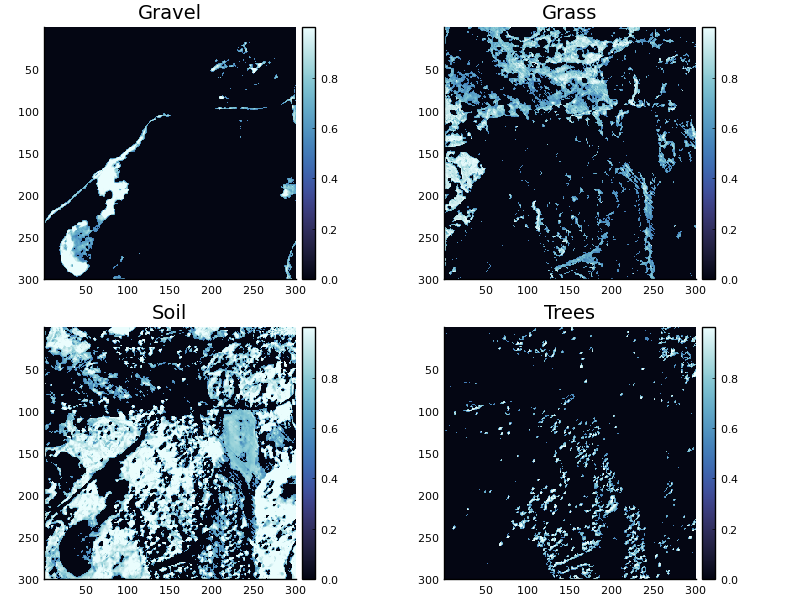

In [24]:
reshape(A[2,:], Int(sqrt(N)), Int(sqrt(N)))

plotFourMaps(A.*(A.>0.5))

Results with Ipopt optimizer:

In [25]:
A = zeros(size(S,2), N)

@time begin
    for i = 1:N
        A[:,i] = JuliaLibrariesJuMP(X[:,i],S,"Ipopt")
    end
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

574.548924 seconds (1.24 G allocations: 95.203 GiB, 1.57% gc time, 0.07% compilation time)


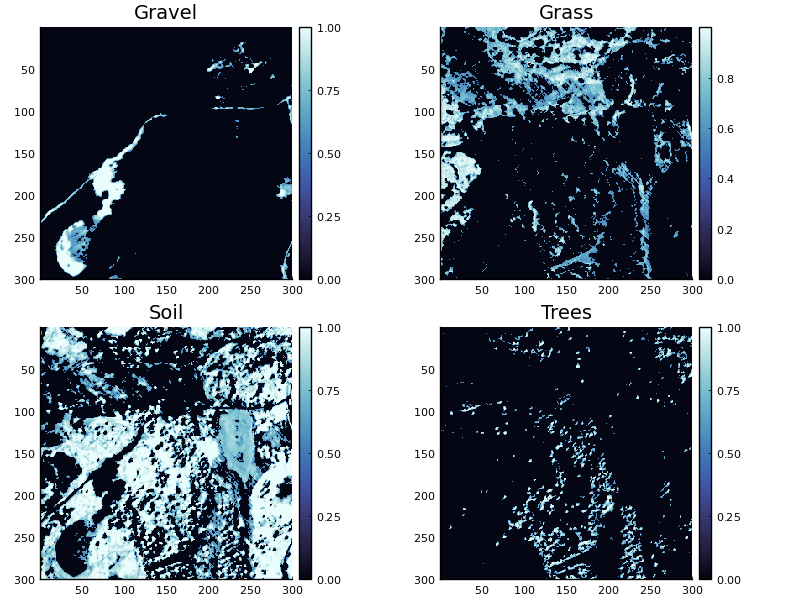

In [26]:
reshape(A[2,:], Int(sqrt(N)), Int(sqrt(N)))

plotFourMaps(A.*(A.>0.5))

The ECOS optimizer appears to be much faster than the Ipopt optimizer. In the next section, when the algorithms are run in parallel, we will only use the ECOS version.

## 2.3 Results

Regarding the 4 images that are plotted after each iteration, all algorithms seem to yield similar results. We can only observe a small difference between the projected gradient descent implementation and the Julia libraries implementation on the Grass plot, where it appears to be brighter when solving the problem via the second method. Still, both methods appear to correctly identify the materials, showing in a brighter color the material in question. However, we cannot really evaluate the performance of the algorithm regarding the results since we do not have a ground truth to which compare it to. Therefore, all we will focus in analyzing the performance of the algothms regarding the computing time. 

In what concerns the Projected Gradient Descent, the pixelwise approach is the fastest and the less expensive in terms of memory usage. The case in where the whole image is computed at once is the complete opposite. Using the Julia libraries, we found that the ECOS optimizer was the fastest of all, beating the second best algorithm (pixelwise projected gradient descent) for around 250 seconds and using a fifth of the memory. In the next section we will compare these results to those obtained by parallelizing. 

# 3. Parallel computing

In this section we will be implementing the same algorithms as in the previous one but this time these will be executed in parallel taking full advantage of the computer's cores. This problem is embarrassingly parallel, since the result is the sum of several independent tasks that must be done across each pixel. Therefore, it would appear to be convenient to parallelize the problem to obtain faster results.

In order to do this, we will be particularily using the function pmap from the library Distributed.

## 3.2 Projected gradient descent algorithm

The tests performed with the Projected Gradient Descent algorithm are studied using parallel computing, except from the one that computes the whole image at once as it was shown that it takes a lot of time in the serial case (in comparison to the other scenarios).

In [27]:
using Distributed: pmap
f_stepsize = 0.005

A = @time pmap(Xi->ProjectedGradientDescent(Xi,S,f,∇f,f_stepsize), [X[:,j] for j = 1:N]);

137.046620 seconds (10.08 M allocations: 882.493 MiB, 0.34% gc time, 0.70% compilation time)


In [28]:
A = hcat(A...)

4×90000 Matrix{Float64}:
 0.0247951  0.0255984  0.0214662  …  0.0179921  0.0449644  0.0389914
 0.4331     0.478292   0.500651      0.303237   0.220565   0.172704
 0.151829   0.159303   0.252069      0.678771   0.734471   0.788305
 0.390275   0.336806   0.225814      0.0        0.0        0.0

In [29]:
size(A)

(4, 90000)

In [30]:
sum(reshape(A[1,:], Int(sqrt(N)), Int(sqrt(N))))

8654.82409972271

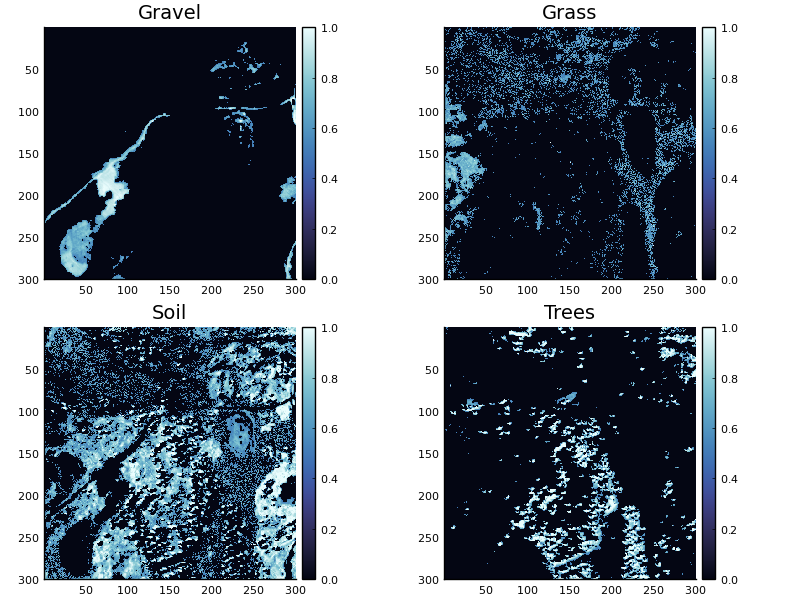

In [31]:
plotFourMaps(A.*(A.>0.5))

In [32]:
f_stepsize = 0.005

A = @time pmap(Xi->ProjectedGradientDescent(Xi,S,f,∇f,f_stepsize), [X[:,j:j+N÷8-1] for j = 1:N÷8:N]);

248.204919 seconds (869.18 k allocations: 232.410 MiB, 0.10% compilation time)


In [33]:
A = hcat(A...)
size(A)

(4, 90000)

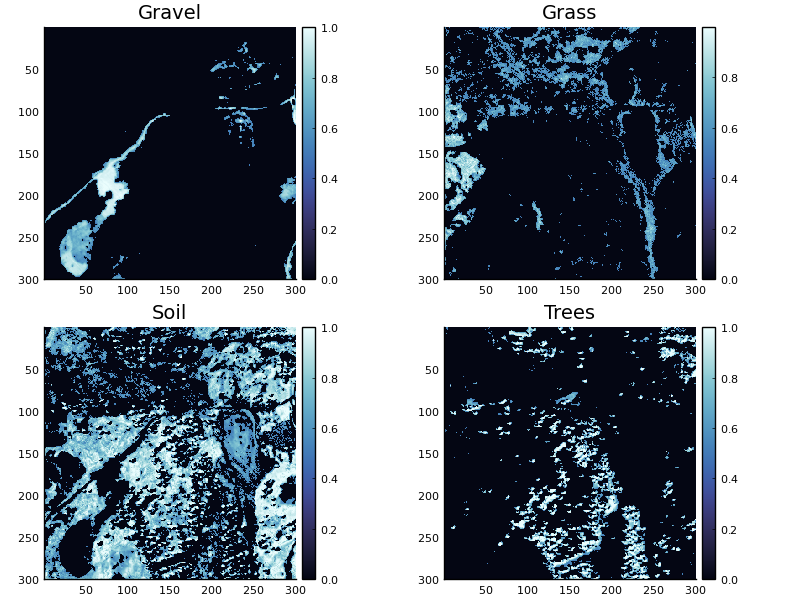

In [34]:
plotFourMaps(A.*(A.>0.5))

## 3.2 Julia libraries

Here we will parallelize the function that was implemented using Julia libraries. The collection of inputs will be all the pixels, since we already identified that the function that is applied to each pixel proves to be an embarrassingly parallel problem. 

In [35]:
A = @time pmap(Xi->JuliaLibrariesJuMP(Xi,S,"ECOS"), [X[:,k] for k = 1:N]);

118.105614 seconds (8.84 M allocations: 800.404 MiB, 0.20% gc time, 0.99% compilation time)


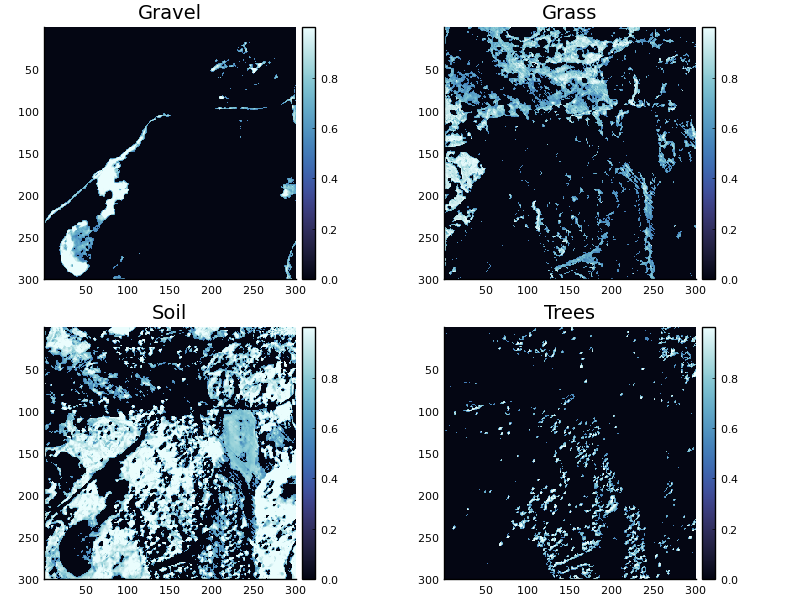

In [36]:
A = hcat(A...)

plotFourMaps(A.*(A.>0.5))

## 3.3 Results

Parallelization reduced the running time to a half when using the Projected Gradient Descent algorithm and considering one eight of the image at a time. On the other hand, the improvement in the pixelwise approach was even better than that.

Using Julia libraries, parallelizing decreases the computing time from around 180 seconds to around 120 seconds, which represents about a 30% improvement in time. 

However, what catches our attention the most is the huge decrease in the allocated memory (in particular, the one eight case becomes the less expensive in this sense). We can conclude that, for these algorithms and conditions, parallelizing seems to improve performance. 

# 4. Parameter tuning

As a side note, it is important to mention that this project had a lot to do with tuning certain parameters. For example, we started by considering a stepsize of $\frac{2}{\lVert \mathbf{S}^T\mathbf{S}\rVert}$ in the Projected Gradient Descent algorithm but, even if it worked, the number $0.012$ proved to be better in terms of computation time - and qualitatively similar-looking maps -. 

Also, a smaller stepsize was used in the final iteration because sometimes, after a gradient step, a column in $\mathbf{\hat{A}}$ (or many of them) could get all negative elements, so when taking the elementwise maximum with zero they would all become $0$. As a matter of fact, those columns would provoke *NaN* elements to appear when dividing $\mathbf{\hat{A}}$ by the sum of its columns (in order to satisfy one of the constraints). Therefore, for each case the final stepsize was chosen after doing some tests.

Another parameter that was studied is the *maximum iteration* one. If too low, the expected maps would not be obtained as the objective function $\mathbf{f}$ would be far away from being minimized.

# 5. Conclusion

In this project we were introduced to parallel computing. Particularily, we were presented with an embarrassingly parallel problem, so at first one could assume that paralellizing would reduce computing time. Also, we were able to solve the Hyperspectral image unmixing problem applying both constraints via two methods: applying projected gradient descent and by using existent Julia optimization libraries.

To begin with, when running the algorithms serially, we found that the projected gradient descent works faster when implementing it pixelwise, followed by an eight of the image at a time way and, lastly, by working with the whole image at once. Also, all these methods were beaten in rapidness by the ECOS optimizer using the Julia libraries. When paralellizing using the *pmap* function of the Distributed library, the results followed a similar order but were all faster than their serial equal. In these cases, parallelizing proved to improve the performance of the algorithms and the allocated memory. This, however, is not always the case since sometimes the overhead cost of separating the algorithm in the different processes takes more time.

To conclude, before deciding whether the parallelization strategy is appropriate, in general, it is necessary to study the type of problem, the algorithm/s that is/are going to be used and the way of performing the computations (in this project: pixelwise, considering the whole image or taking an eighth of it).